<h3>Tokenizer Evaluation on HAR, Sex 

Compare classification of magnitude model to tokenized magnitude with various quantisations. 

In [2]:
# Configure GPU

import sys

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm

import utils

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)
cudnn.benchmark = True


/home/hrs675/Wearables_Tokenizer/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set up

In [1]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Compiled with CUDA:", torch.version.cuda)
print("GPU support enabled:", torch.backends.cuda.is_built())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

PyTorch version: 2.7.0+cu126
CUDA available: True
Compiled with CUDA: 12.6
GPU support enabled: True
Using device: cuda


Load data

In [3]:
import pandas as pd

#tokenized string for each participant - about a day of data. 
pid_tokens=pd.read_csv("/home/hrs675/Wearables_Tokenizer/data/pid_token_string_numbers.csv")

In [4]:
pid_tokens['pid'] = pid_tokens['pid'].str[:4]
pid_tokens.head()

,pid,token_string
0,P030,1 b 1 b 3 bb 4 b 3 bbb 1 bb 4 b 2 b 1 bb 4 bb...
1,P036,kjfgghhjlhhhihhighggjigheddddddcdefefeekkgjjhi...
2,P113,bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbcbbbebbbbb...
3,P048,cbb 2 gebbbb 1 bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb...
4,P099,1 c 1 cbbcbbbbbbccccccccccccccccccccccccccccc...


In [5]:
metadata= pd.read_csv("/data/UKBB/kyra/capture24/metadata.csv")

In [6]:
#combine meta data and token strings]
meta_tokens= pd.merge(metadata, pid_tokens, on='pid', how='inner')
meta_tokens.head()

,pid,age,sex,token_string
0,P001,38-52,F,bb 3 bbbbbbbbb 1 bbbbbbbbbbbbbbbbbbbbbbbbbbbbb...
1,P002,30-37,F,cccbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb...
2,P003,30-37,F,bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb...
3,P004,53+,F,21 b 3 ebbbbbbbbbcbbbbbbbbbcbbbbbbbdgbbbbcbbb...
4,P005,38-52,F,cccccccccccccccccccccccccccccccccccccccccccccc...


In [7]:
# Save the combined meta_tokens DataFrame to CSV
meta_tokens.to_csv("/home/hrs675/Wearables_Tokenizer/data/meta_tokens.csv", index=False)

Train/ Test split

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tokenizers import Tokenizer
import numpy as np


In [11]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Should be >= 1


True
3


In [9]:
# Your raw inputs
X = meta_tokens['token_string']
Y = meta_tokens['sex']

# Load your tokenizer
tokenizer = Tokenizer.from_file("/home/hrs675/Wearables_Tokenizer/Trained Tokenizers/trained_tokenizer_2.json")

def encode_token_string(tokenizer, s, max_len=512):
    ids = tokenizer.encode(s).ids
    if len(ids) < max_len:
        ids += [0] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

X_ids = [encode_token_string(tokenizer, s) for s in X]

# Encode labels (e.g., Male/Female -> 0/1)
le = LabelEncoder()
Y_encoded = le.fit_transform(Y)

# Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(X_ids, Y_encoded, test_size=0.2, random_state=42)


In [10]:
class TokenSexDataset(Dataset):
    def __init__(self, X_token_ids, Y_sex):
        self.X = torch.tensor(X_token_ids, dtype=torch.long)
        self.Y = torch.tensor(Y_sex, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


In [11]:
class TransformerWithSex(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, nhead=4, num_layers=2, max_len=512, sex_emb_dim=16, num_classes=2):
        super().__init__()

        self.token_emb = nn.Embedding(vocab_size, emb_dim)
        self.pos_emb = nn.Parameter(torch.zeros(1, max_len, emb_dim))
        self.sex_emb = nn.Embedding(2, sex_emb_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Sequential(
            nn.Linear(emb_dim + sex_emb_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, token_ids, sex):
        x = self.token_emb(token_ids) + self.pos_emb[:, :token_ids.size(1), :]
        x = self.transformer(x)
        x_pooled = x.mean(dim=1)
        sex_e = self.sex_emb(sex)
        x_combined = torch.cat([x_pooled, sex_e], dim=1)
        return self.fc(x_combined)


In [12]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [13]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [14]:
# Dataloaders
train_loader = DataLoader(TokenSexDataset(X_train, Y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TokenSexDataset(X_test, Y_test), batch_size=32)

# Model, loss, optimizer
model = TransformerWithSex(vocab_size=tokenizer.get_vocab_size()).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


/home/hrs675/Wearables_Tokenizer/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [15]:
train_losses = []
train_accuracies = []
test_accuracies = []
epochs = 20

In [16]:

for epoch in range(epochs):
    model.train()
    total_loss = 0
    train_preds, train_labels = [], []

    for token_ids_batch, sex_batch in train_loader:
        token_ids_batch = token_ids_batch.to(device)
        sex_batch = sex_batch.to(device)

        optimizer.zero_grad()
        outputs = model(token_ids_batch, sex_batch)
        loss = criterion(outputs, sex_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(sex_batch.cpu().numpy())

    train_acc = accuracy_score(train_labels, train_preds)
    train_accuracies.append(train_acc)
    train_losses.append(total_loss)

    # Evaluation
    model.eval()
    test_preds, test_labels = [], []

    with torch.no_grad():
        for token_ids_batch, sex_batch in test_loader:
            token_ids_batch = token_ids_batch.to(device)
            sex_batch = sex_batch.to(device)
            outputs = model(token_ids_batch, sex_batch)
            preds = torch.argmax(outputs, dim=1)

            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(sex_batch.cpu().numpy())

    test_acc = accuracy_score(test_labels, test_preds)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")


Epoch 1/20 | Loss: 2.4308 | Train Acc: 0.6667 | Test Acc: 0.6129
Epoch 2/20 | Loss: 2.1374 | Train Acc: 0.6667 | Test Acc: 0.6129
Epoch 3/20 | Loss: 2.0896 | Train Acc: 0.6667 | Test Acc: 0.6129
Epoch 4/20 | Loss: 2.0325 | Train Acc: 0.6667 | Test Acc: 0.6129
Epoch 5/20 | Loss: 1.9866 | Train Acc: 0.6667 | Test Acc: 0.6129
Epoch 6/20 | Loss: 1.9531 | Train Acc: 0.6667 | Test Acc: 0.6129
Epoch 7/20 | Loss: 1.9551 | Train Acc: 0.6667 | Test Acc: 0.6129
Epoch 8/20 | Loss: 1.8903 | Train Acc: 0.6667 | Test Acc: 0.6129
Epoch 9/20 | Loss: 1.8723 | Train Acc: 0.6667 | Test Acc: 0.6129
Epoch 10/20 | Loss: 1.8333 | Train Acc: 0.7417 | Test Acc: 0.6452
Epoch 11/20 | Loss: 1.7960 | Train Acc: 0.6917 | Test Acc: 0.6129
Epoch 12/20 | Loss: 1.7695 | Train Acc: 0.6750 | Test Acc: 0.6129
Epoch 13/20 | Loss: 1.7472 | Train Acc: 0.6750 | Test Acc: 0.6129
Epoch 14/20 | Loss: 1.7058 | Train Acc: 0.7333 | Test Acc: 0.9677
Epoch 15/20 | Loss: 1.6757 | Train Acc: 0.9833 | Test Acc: 1.0000
Epoch 16/20 | Loss:

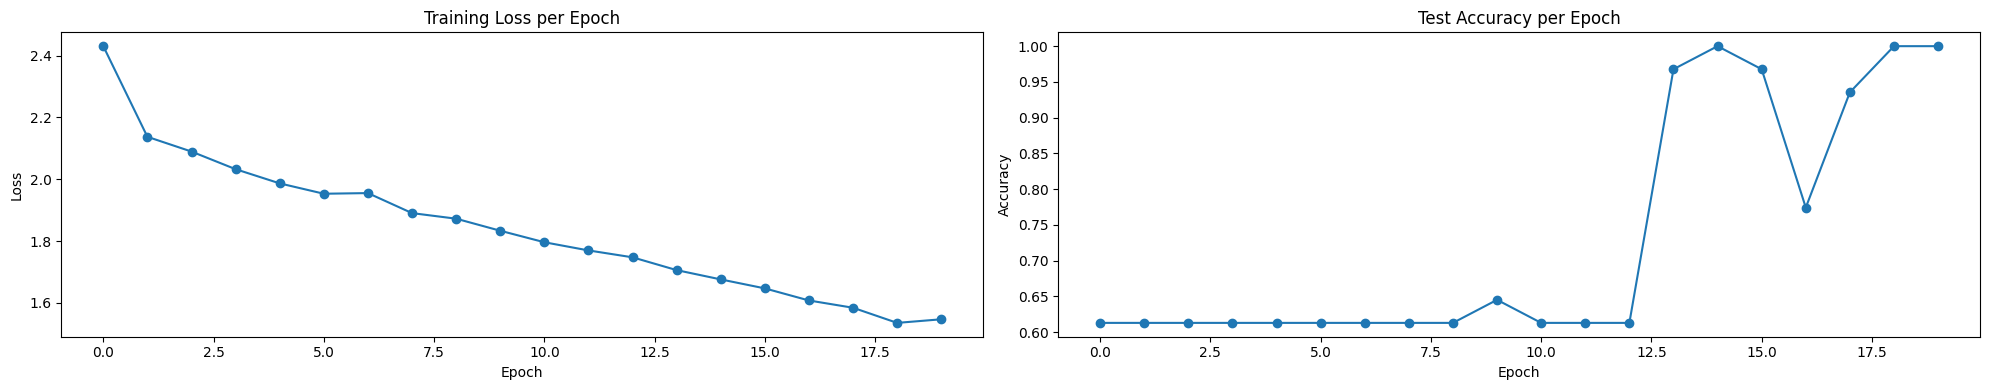

In [18]:
plt.figure(figsize=(20, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, marker='o')
plt.title("Test Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


In [22]:
import pandas as pd

# Decode numeric labels back to original "Male"/"Female" labels
actual_labels = le.inverse_transform(test_labels)
predicted_labels = le.inverse_transform(test_preds)

# Create DataFrame to show results
results_df = pd.DataFrame({
    "Actual Sex": actual_labels,
    "Predicted Sex": predicted_labels
})

# Display first 20 rows (or all)
print(results_df.head(25))  # or .to_string(index=False) for cleaner output


   Actual Sex Predicted Sex
0           F             F
1           F             F
2           M             M
3           M             M
4           M             M
5           M             M
6           F             F
7           F             F
8           F             F
9           F             F
10          F             F
11          M             M
12          F             F
13          F             F
14          M             M
15          F             F
16          F             F
17          F             F
18          M             M
19          M             M
20          M             M
21          F             F
22          F             F
23          F             F
24          F             F
